In [6]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# model_name = "EmbeddingAndCNNModel"
# model_name = "EmbeddingAnd2dCNNModel"
model_name = "ResNet50"
# model_name = "Simple2d"
# target_feature = "endianness"
target_feature = "instructionwidth_type"

In [7]:
# Specify the directory containing the CSV files
directory = "../../results/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "*.csv"))
df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

# Filter on model and target feature
df = df[
    (df["model.name"] == model_name) & (df["target_feature"] == target_feature)
].reset_index(drop=True)

In [8]:
# Compute mean and std of overall accuracy
df_overall = df[df["Name"] == "overall_metrics"][["overall_accuracy"]]
overall_mean = df_overall["overall_accuracy"].mean()
overall_std = df_overall["overall_accuracy"].std()

# Remove unnecessary columns
df_filtered = df[["Name", "test_accuracy", "test_loss", "train_loss"]]

# Remove aggregation rows and rename columns
df_folds = df_filtered[df_filtered["Name"] != "overall_metrics"].rename(
    columns={"Name": "architecture"}
)

df_folds["architecture"] = df_folds["architecture"].str.removeprefix("fold_")

df_folds.head()

,architecture,test_accuracy,test_loss,train_loss
1,x32,0.969828,0.114119,0.028593
2,sparc64,0.856532,0.364191,0.024838
3,sparc,0.809438,0.417446,0.028149
4,sh4,0.990556,0.032965,0.029408
5,s390x,0.957603,0.095349,0.026562


In [9]:
df_agg = (
    df_folds.groupby("architecture")
    .agg({"test_accuracy": ["mean", "std"]})
    .sort_values(("test_accuracy", "mean"), ascending=False)
    .reset_index()
)

df_agg

architecture test_accuracy          
                         mean       std
0       powerpc      0.999449  0.000435
1         armel      0.997200  0.002471
2    powerpcspe      0.991568  0.011733
3        mipsel      0.985960  0.001155
4          mips      0.984684  0.010796
5         arm64      0.983993  0.008720
6       ppc64el      0.969912  0.027417
7           x32      0.967960  0.002542
8          hppa      0.961035  0.045672
9         armhf      0.949887  0.013070
10          sh4      0.938280  0.114258
11      sparc64      0.893101  0.077427
12     mips64el      0.870918  0.070490
13        amd64      0.865735  0.006217
14      riscv64      0.859234  0.056961
15         i386      0.838207  0.039617
16         m68k      0.812227  0.171113
17        ppc64      0.776491  0.163329
18        sparc      0.756426  0.171700
19        s390x      0.561447  0.369824
20        alpha      0.331654  0.314237
21         s390      0.326026  0.393461
22         ia64      0.000762  0.000609

| Architecture | Mean Accuracy | Standard Deviation |
|--------------|--------------:|--------:|
| powerpc | 0.999 | 0.000 |
| armel | 0.997 | 0.002 |
| powerpcspe | 0.992 | 0.012 |
| mipsel | 0.986 | 0.001 |
| mips | 0.985 | 0.011 |
| arm64 | 0.984 | 0.009 |
| ppc64el | 0.970 | 0.027 |
| x32 | 0.968 | 0.003 |
| hppa | 0.961 | 0.046 |
| armhf | 0.950 | 0.013 |
| sh4 | 0.938 | 0.114 |
| sparc64 | 0.893 | 0.077 |
| mips64el | 0.871 | 0.070 |
| amd64 | 0.866 | 0.006 |
| riscv64 | 0.859 | 0.057 |
| i386 | 0.838 | 0.040 |
| m68k | 0.812 | 0.171 |
| ppc64 | 0.776 | 0.163 |
| sparc | 0.756 | 0.172 |
| s390x | 0.561 | 0.370 |
| alpha | 0.332 | 0.314 |
| s390 | 0.326 | 0.393 |
| ia64 | 0.001 | 0.001 |
| **Overall** | **0.798** | **0.040** |


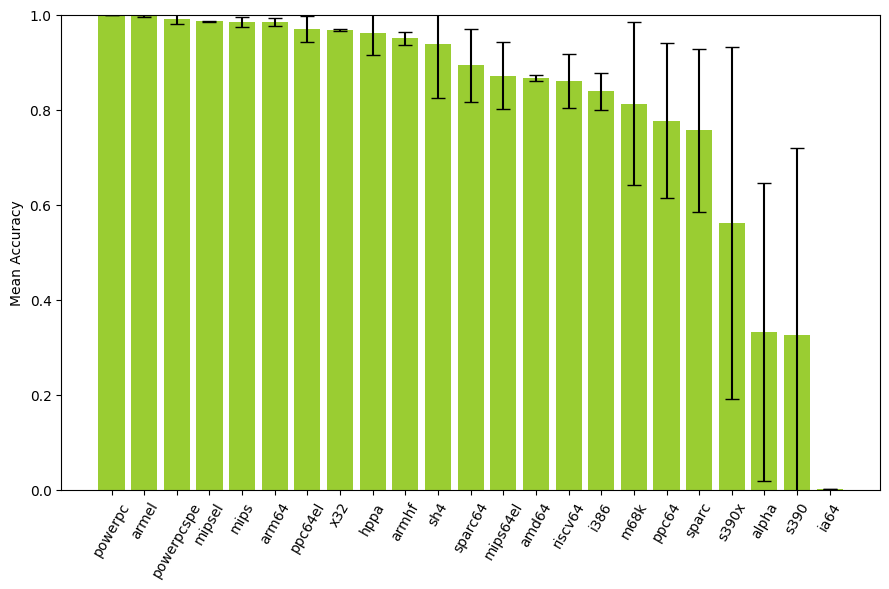

In [10]:
means = df_agg[("test_accuracy", "mean")].values
stds = df_agg[("test_accuracy", "std")].values
architectures = df_agg["architecture"].values

# Create markdown table header
print("| Architecture | Mean Accuracy | Standard Deviation |")
print("|--------------|--------------:|--------:|")

# Print each architecture's stats in table format
for arch, mean, std in zip(architectures, means, stds):
    print(f"| {arch} | {mean:.3f} | {std:.3f} |")

# Print overall accuracy and std as last row in table
print(f"| **Overall** | **{overall_mean:.3f}** | **{overall_std:.3f}** |")


plt.figure(figsize=(9, 6))
bars = plt.bar(
    range(len(architectures)), means, yerr=stds, capsize=5, color="yellowgreen"
)

# # Add value labels at the bottom of each bar with improved styling
# for bar in bars:
#     height = bar.get_height()
#     plt.text(
#         bar.get_x() + bar.get_width() / 2.0,
#         0.01,
#         f"{height:.2f}",
#         ha="center",
#         va="bottom",
#         rotation=0,
#         color="black",
#         fontsize=8,
#         fontweight="bold",
#         bbox=dict(
#             facecolor="white",
#             edgecolor="gray",
#             boxstyle="round,pad=0.2",
#             linewidth=0.5,
#             alpha=0.9,
#         ),
#     )

plt.xticks(range(len(architectures)), architectures, rotation=60)
# plt.title(f"Overall accuracy: {overall_mean:.3f} ± {overall_std:.3f}")
plt.ylabel("Mean Accuracy")
plt.ylim(0, 1)

plt.tight_layout()